# CNNs in Depth

## Convolutional layers in depth

Definitions:
- dense layers = fully connected layers, meaning that the nodes are connected to every node in the previous layer
- locally-connected layers (convolutional layers) = meaning that the nodes are only connected to a small subset of the previous layer nodes

Kernels for color images:
- grayscale images uses a matrix of `kernel_size` x `kernel_size` numbers
- color images uses a 3d filter of `kernel_size` x `kernal_size` x 3 for RGB colors

"Channels" indicate the feature maps of convolutional layers: a convolutional layer that takes feature maps with a depth of 64 and outputs 128 feature maps is said to have 64 channels as input and 128 as outputs.

### The number of parameters in a convolutional layer
The number of parameters in a convolutional layer is the number of filters times the number of input feature maps times the size of the kernel squared plus the number of kernels:
- $n_k$​ : number of filters in the convolutional layer
- $k$ : height and width of the convolutional kernel
- $c$ : number of feature maps produced by the previous layer (or number of channels in input image)

There are k times k times c weights per filter plus one bias per filter, so $c*k2 + 1$ parameters. The convolutional layer is composed of $n_k$​ filters, so the total number of parameters in the convolutional layer is: $n_p = n_k (c k^2 + 1)$


## Convolutional Layers in PyTorch

Example code to create a convolutional layer:
```python
from torch import nn
conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
```

We can also add an activation and dropout function. In case of CNNs, we need to use the 2d version of dropout, which randomly drops some input channel entirely:
```python
conv_block = nn.Sequential(
  nn.Conv2d(in_channels, out_channels, kernel_size),
  nn.ReLU(),
  nn.Dropout2d(p=0.2)
)
```

## Stride and padding

Padding and stride are hyperparameters, or configuration settings, for the filter:
- Padding: Expanding the size of an image by adding pixels at its border
- Stride: Amount by which a filter slides over an image.

There are multiple padding strategies:
- zero-padding strategy is by far the most common: padding values will all be 0
- reflect: padding pixels filled with copies of values in input image taken in opposite order, in a mirroring fashion
- replicate: padding pixels filled with value of closest pixel in input image
- circular: like reflect mode, but image is first flipped horizontally and vertically

## Pooling layers

Also for pooling layers you can set the padding and stride paramters.

Different padding strategies:
- max-pooling: take the maximum value in the window = mostly used for images
- average-pooling: take mean average of all the values in the window

Example code for max and average pooling:
```python
from torch import nn
nn.MaxPool2d(kernel_size, stride)
nn.AvgPool2d(window_size, stride)
```

Definitions:
- Kerel size: size of the side of the convolutional kernel
- Window size: size of the window considered during pooling
- Stride: Step size of the convolutional kernel or of the pooling window when moving over the input image
- Padding: Border to add to an input image before the convolution operation is performed

## Typical structure of CNNs

Example code of typical convolutional layer:
```python
conv1 = nn.Conv2d(
    depth_of_input_layer, # for an RBG image, the input size is 3
    desired_depth_of_output, # if we want 16 filters, this will be 16
    kernel_size, # size of the filter
    stride, # default is 1
    padding, # default is 0
)
```

A classical CNN is made of two distinct parts, sometimes called the backbone and the head:
- The **backbone** is made of convolutional and pooling layers, and has the task of extracting information from the image.
- After the backbone there is a flattening layer that takes the output feature maps of the previous convolutional layer and flattens them out in a 1d vector: for each feature map the rows are stacked together in a 1d vector, then all the 1d vectors are stacked together to form a long 1d vector called a feature vector or embedding.

### A simple CNN

Example of a simple CNN in Pytorch:
```python
import torch
import torch.nn as nn

class MyCNN(nn.Module):

  def __init__(self, n_classes):

    super().__init__()

    # Create layers. In this case just a standard MLP
    self.model = nn.Sequential(
      # First conv + maxpool + relu
      nn.Conv2d(3, 16, 3, padding=1),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
      nn.Dropout2d(0.2),

      # Second conv + maxpool + relu
      nn.Conv2d(16, 32, 3, padding=1),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
      nn.Dropout2d(0.2),

      # Third conv + maxpool + relu
      nn.Conv2d(32, 64, 3, padding=1),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
      nn.Dropout2d(0.2),

      # Flatten feature maps
      nn.Flatten(),

      # Fully connected layers. This assumes
      # that the input image was 32x32
      nn.Linear(1024, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, n_classes)
    )

  def forward(self, x):

    # nn.Sequential will call the layers 
    # in the order they have been inserted
    return self.model(x)
```

### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
- We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by: $\frac{{\text{{Input size W}} - \text{{Kernel size F}} + 2 \times \text{{Padding P}}}}{{\text{{Stride S}}}} + 1$


For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output:
- W = 7
- F = 3
- S = 1
- P = 0
- ((7-3+2*0)/1) + 1 = 5

With stride 2 we would get a 3x3 output.

## Data augmentation

The basic idea of image augmentation is the following: if you want your network to be insensitive to changes such as rotation, translation, and dilation, you can use the same input image and rotate it, translate it, and scale it and ask the network not to change its prediction!

Image augmentation is a very common method to:
- Increase the robustness of the network
- Avoid overfitting
- Introduce rotational, translational and scale invariance as well as insensitiveness to color changes
- Avoid shortcut learning

A typical training augmentation pipeline in Pytorch:
```python
import torchvision.transforms as T

train_transforms = T.Compose(
    [
        # The size here depends on your application. Here let's use 256x256
        T.Resize(256),
        # Let's apply random affine transformations (rotation, translation, shear)
        # (don't overdo here!)
        T.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10),
        # Color modifications. Here I exaggerate to show the effect 
        T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        # Apply an horizontal flip with 50% probability (i.e., if you pass
        # 100 images through around half of them will undergo the flipping)
        T.RandomHorizontalFlip(0.5),
        # Finally take a 224x224 random part of the image
        T.RandomCrop(224, padding_mode="reflect", pad_if_needed=True),  # -
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
```

Note that image augmentation is not needed for the validation and test set. However:
- The resize and crop should be the same as applied during training for best performance
- The normalization should be the same between training and inference (validation and test)

Example code of test and validation pipeline in Pytorch:
```python
testval_transforms = T.Compose(
    [
        # The size here depends on your application. Here let's use 256x256
        T.Resize(256),
        # Let's take the central 224x224 part of the image
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
```

## BatchNorm

BatchNorm normalizes the activations and keep them much more stable during training, making the training more stable and the convergence faster.

Advantages of BatchNorm:
- easily added to most architectures
- faster training
- reduce sensitivity to initialisation
- small regularization effect

Disadvantages of BatchNorm:
- breaks with small batch size
- difference between train and inference
- added computation for inference

These advantages of using BatchNorm generally outweigh these disadvantages, so BatchNorm is widely used in almost all CNN implementations today.

Example of adding BatchNorm:
```python
self.conv1 = nn.Sequential(
  nn.Conv2d(3, 16, kernel_size=3, padding=1),
  nn.BatchNorm2d(16),
  nn.MaxPool2d(2, 2),
  nn.ReLU(),
  nn.Dropout2d(0.2)
)
```

For MLPs, we use the 1d BatchNorm:
```python
self.mlp = nn.Sequential(
  nn.Linear(1024, 500),
  nn.BatchNorm1d(500),
  nn.ReLU(),
  nn.Dropout(0.5)
)
```

## Parameters and hyperparameters
Important Terms in Optimizing Performance.

Parameter:
- Internal to the model
- May vary during training
- Examples: Weights and biases of a network

Hyperparameter
- External to the model
- Fixed during training
- Examples: Learning rate, number of layers, activation layers

Experiment
- A specific training run with a fixed set of hyperparameters
- Practitioners typically perform many experiments varying the hyperparameters. Each experiment produces one or more metrics that can be used to select the best-performing set of hyperparameters (see the next section).


Strategies for Optimizing Hyperparameters:

Grid search
- Divide the parameter space in a regular grid
- Execute one experiment for each point in the grid
- Simple, but wasteful

Random search
- Divide the parameter space in a random grid
- Execute one experiment for each point in the grid
- Much more efficient sampling of the hyperparameter space with respect to grid search

Bayesian Optimization
- Algorithm for searching the hyperparameter space using a Gaussian Process model
- Efficiently samples the hyperparameter space using minimal experiments


### Most important hyperparameters

- Design parameters: When you are designing an architecture from scratch, the number of hidden layers, as well as the layers parameters (number of filters, width and so on) are going to be important.
- Learning rate: Once the architecture is fixed, this is typically the most important parameter to optimize. The next video will focus on this.
- Batch size: This is typically the most influential hyperparameter after the learning rate. A good starting point, especially if you are using BatchNorm, is to use the maximum batch size that fits in the GPU you are using. Then you vary that value and see if that improves the performances.
- Regularization: Once you optimized the learning rate and batch size, you can focus on the regularization, especially if you are seeing signs of overfitting or underfitting.
- Optimizers: Finally, you can also fiddle with the other parameters of the optimizers. Depending on the optimizers, these vary. Refer to the documentation and the relevant papers linked there to discover what these parameters are.

The learning rate is the most important hyperparameter. In many cases we want to vary the learning rate as the training progresses. At the beginning of the training we want to make pretty large steps because we are very far from the optimum. However, as we approach the minimum of the loss, we need to make sure we do not jump over the minimum.
- For this reason, it is often a good idea to use a learning rate scheduler, i.e., a class that changes the learning rate as the training progresses.
  
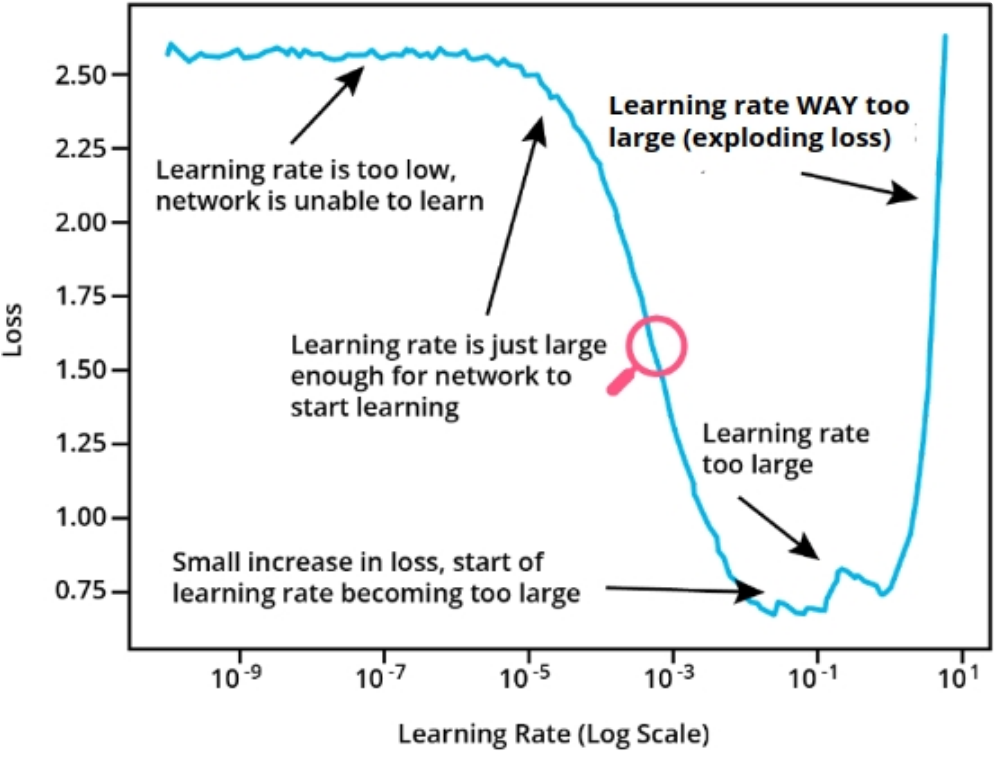



# Misc

A tensor can be moved to GPU or CPU by:
```python
tensor.cuda()
tensor.cpu()
```

CUDA is a parallel computing platform
